In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from MODULES.vae_model import *
from MODULES.utilities_ml import process_one_epoch
from MODULES.utilities_visualization import show_batch

# Check versions
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


In [3]:
params = load_json_as_dict("./ML_parameters.json")
vae = CompositionalVae(params)

In [4]:
# params

In [5]:
image_size = params['input_image']['size_raw_image']
b, c, w, h = 8, params['input_image']['ch_in'], image_size, image_size
imgs_in = torch.sigmoid(torch.randn(b,c,w, h))

optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])

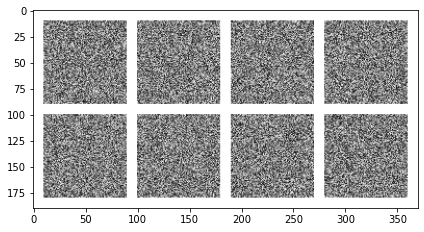

In [6]:
show_batch(imgs_in)

In [16]:
generated = vae.generate(imgs_in, draw_boxes=True)

torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([3])


AssertionError: 

('metrics', 'inference', 'imgs')
('logit_map', 'logit_few', 'big_bg', 'big_img', 'big_mask', 'big_mask_NON_interacting', 'sample_c_map', 'sample_c', 'sample_bb', 'sample_zinstance', 'kl_logit', 'kl_zwhere', 'kl_zinstance')
torch.Size([8, 1, 20, 20])


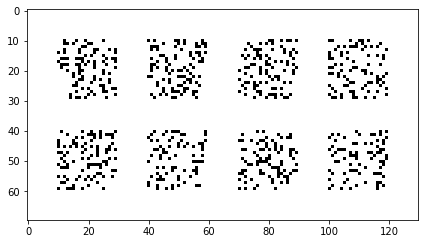

In [11]:
print(generated._fields)
print(generated.inference._fields)
print(generated.inference.sample_c_map.shape)
show_batch(generated.inference.sample_c_map.float())

Uninitialized: You must initialize neptune-client first. For more information, please visit: https://github.com/neptune-ai/neptune-client#initialize-neptune

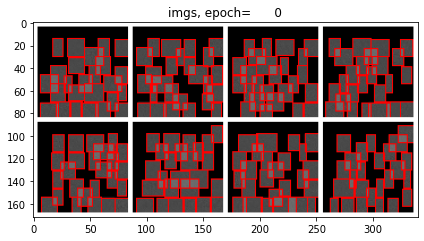

In [12]:
from MODULES.utilities_visualization import plot_reconstruction_and_inference, plot_segmentation

plot_reconstruction_and_inference(generated, epoch=0, prefix="gen_")

In [14]:
output = vae.forward(imgs_in, draw_image=True, draw_boxes=True, verbose=False)

AAAA torch.float32
BBB -> torch.float32
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([3])


In [ ]:
output.inference.sample_bb.bh[..., 0]
print(vae.inference_and_generator.size_min)
print(vae.inference_and_generator.size_max)

In [ ]:
plot_reconstruction_and_inference(output, epoch=0, prefix="rec_")

In [ ]:
vae